In [1]:
#　colaboratory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [3]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220301/MiniCTorch_Prototype/notebook


In [4]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from tqdm import tqdm, trange

In [5]:
DEVICE = 'cpu' #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
BATCH_SIZE = 4
TEST_BATCH_SIZE = 5

"""
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fmnist', train=True, download=True,
    transform=transforms.ToTensor()), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fmnist', train=False, download=True,
    transform=transforms.ToTensor()), batch_size=TEST_BATCH_SIZE, shuffle=False)
"""

fashion_mnist_train = datasets.FashionMNIST('./fmnist', train=True,  download=True,transform=transforms.ToTensor())
fashion_mnist_test  = datasets.FashionMNIST('./fmnist', train=False, download=True,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader( fashion_mnist_train, batch_size=BATCH_SIZE, shuffle=True )
test_loader  = torch.utils.data.DataLoader( fashion_mnist_test , batch_size=BATCH_SIZE, shuffle=True )

TRAIN_SIZE  = len(train_loader.dataset)
TEST_SIZE   = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 1
SAMPLES = 2
TEST_SAMPLES = 10


In [7]:
print("train_size",TRAIN_SIZE)
print("test_size",TEST_SIZE)
print("num_batches",NUM_BATCHES)
print("num_test_batches",NUM_TEST_BATCHES)
print("fashion_mnist_train", len(fashion_mnist_train))
print("fashion_mnist_test" , len(fashion_mnist_test))
fashion_mnist_test


train_size 60000
test_size 10000
num_batches 15000
num_test_batches 2500
fashion_mnist_train 60000
fashion_mnist_test 10000


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./fmnist
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (- math.log(math.sqrt(2 * math.pi)) - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [9]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

In [10]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        PI = 0.5
        SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(DEVICE)
        SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(DEVICE)
        self.weight_p = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_p   = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_p = 0
        self.log_q = 0

    def forward(self, input, sample=False,):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        self.log_p = self.weight_p.log_prob(weight) + self.bias_p.log_prob(bias)
        self.log_q = self.weight.log_prob(weight)   + self.bias.log_prob(bias)
        return F.linear(input, weight, bias)
    

In [11]:
SAMPLES = 3
DEVICE  = 'cpu'

"""
class BBBLoss(nn.Module):  #BBBLoss(nn.Module):
  def __init__(self, samples=SAMPLES):
    super().__init__()
    self.samples = samples

  def forward( self, x, target, model ):
    #print("loss forward")
    #print("x",x)
    #print("target",target)
    outputs, log_ps, log_qs = model.sample(x,samples=self.samples)
    #print("outputs",outputs)
    #print("log_ps",log_ps)
    #print("log_qs",log_qs)
    log_p = log_ps.mean()
    log_q = log_qs.mean()
    #print("log_ps2",log_ps)
    #print("log_qs2",log_qs)
    nll = F.nll_loss(outputs.mean(0), target, size_average=False)
    loss = (log_q - log_p)/NUM_BATCHES + nll
    return loss
"""
    
class Net(nn.Module):   #BayesianNetwork(nn.Module):
    def __init__(self, samples=SAMPLES):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
        self.samples = samples
    
    """
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    """
    """ #220107 mod
    def sample(self, x, samples=SAMPLES):
      outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
      log_ps = torch.zeros(samples).to(DEVICE)
      log_qs = torch.zeros(samples).to(DEVICE)
      for i in range(samples):
          outputs[i] = self(x, sample=True)
          log_ps[i] = self.log_p()
          log_qs[i] = self.log_q()
      return outputs, log_ps, log_qs
    """

    def logsoftmax(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x

    def sampling(self, x, samples=SAMPLES ):
      outputs = [] #torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
      log_ps  = [] #torch.zeros(samples).to(DEVICE)
      log_qs  = [] #torch.zeros(samples).to(DEVICE)
      for i in range(samples):
          #outputs.append( self(x, sample=True) )
          outputs.append( self.logsoftmax(x, sample=True) )
          log_ps.append( self.log_p() )
          log_qs.append( self.log_q() )
      outputs = torch.stack(outputs)
      log_ps  = torch.stack(log_ps)
      log_qs  = torch.stack(log_qs)
      return outputs, log_ps, log_qs
    
    def log_p(self):
        return self.l1.log_p + self.l2.log_p + self.l3.log_p
    
    def log_q(self):
        return self.l1.log_q + self.l2.log_q + self.l3.log_q

    def forward(self, x, sample=False):
       #return self.sampling( x, samples=self.samples )
       outputs, log_ps, log_qs = self.sampling( x, samples=self.samples )
       #return outputs, log_ps, log_qs
       output = outputs.mean(0)
       log_p = log_ps.mean()
       log_q = log_qs.mean()
       return output, log_p, log_q
    
class Loss(nn.Module):  #BBBLoss(nn.Module):
  def __init__(self):
     super().__init__()

  def forward( self, target, output, log_p, log_q ):
     nll = F.nll_loss( output, target, size_average=False )
     loss = (log_q - log_p)/NUM_BATCHES + nll
     return loss

class Model(nn.Module):  # Net(nn.Module)
  def __init__(self, target, samples=SAMPLES):
    super().__init__()
    self.samples = samples
    self.net = Net()  #BayesianNetwork()
    self.net.train()
    self.loss = Loss()  #BBBLoss()  loss_func
    self.target = target
    #print("samples",samples)
    print("target",target)

  def forward(self, x):
    #loss = self.loss_func( x, self.target, self.net )
    output, log_p, log_q = self.net( x )
    loss = self.loss( self.target, output, log_p, log_q )
    return loss


In [ ]:
#learning loop
model=Model(None)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters())

for epoch in range(TRAIN_EPOCHS):
  sum_loss=0
  sum_count=0
  for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
    data, target = data.to(DEVICE), target.to(DEVICE)
    model.zero_grad()
    model.target=target
    loss = model(data)
    loss.backward()
    optimizer.step()
    sum_loss+=loss.item()
    sum_count+=1
  avg_loss=sum_loss/sum_count
  print(avg_loss)

## Installation of MiniCTorch

In [13]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 27.0 MB/s 


In [ ]:
#import minictorch
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [14]:
project = 'bbb3'
folder = './bbb'
json_path = folder + '/' + project +'.json'

In [15]:
! mkdir -p bbb

In [16]:
! jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

Traceback (most recent call last):
  File "/usr/local/bin/jupyter-notebook", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-7>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    return method(app, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/notebook/notebookapp.py", line 1368, in initialize
    self.init_webapp()
  File "/usr/local/lib/python2.7/dist-packages/notebook/notebookapp.py", line 1188, in init_webapp
    self.http_server.listen(port, self.ip)
  File "/usr/local/lib/python2.7/dist-packages/torna

In [17]:
def generate_json( json_path, x,y ):
  with torch.no_grad():
    model = Model(y)  #Net(y)
    print("[SAVE]", json_path )
    minictorch.trace( model, x, json_path )
  return model

In [18]:
import minictorch

torch.manual_seed( 1 )
for data, target in train_loader:
  x=data
  y=target
  break

model = generate_json( json_path, x, y )

target tensor([5, 4, 9, 4])
[SAVE] ./bbb/bbb3.json


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:991: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 0.6350860595703125 (up to 1e-05 allowed)
Relative difference: 0.004271569651237078 (up to 1e-05 allowed)
  _module_class,


skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l2]/weight_rho/l2
skip: Model/Net[net]/BayesianLinear[l2]/weight_rho/l2
skip: Model/Net[net]/BayesianLinear[l2]/weight_rho/l2
skip: Model/Net[net]/BayesianLinear[l2]/weight_rho/l2
skip: Model/Net[net]/BayesianLinear[l3]/weight_rho/l3
skip: Model/Net[net]/BayesianLinear[l3]/weight_rho/l3
skip: Model/Net[net]/BayesianLinear[l3]/weight_rho/l3
skip: Model/Net[net]/BayesianLinear[l3]/weight_rho/l3
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l1]/weight_rho/l1
skip: Model/Net[net]/BayesianLinear[l2]/weight_rho/l2
skip: Model/Net[net]/BayesianLinear[l2]/weight_rho/l2
skip: Model/Net[net]/Bayesia

In [19]:
print("x shape", x.shape)
print("y shape", y.shape)

x shape torch.Size([4, 1, 28, 28])
y shape torch.Size([4])


In [20]:
train_loader2 = torch.utils.data.DataLoader( fashion_mnist_train, batch_size=40, shuffle=True )
for data, target in train_loader2:
  x2=data
  y2=target
  break
print("x2 shape",x2.shape)
print("y2 shape",y2.shape)

x2 shape torch.Size([40, 1, 28, 28])
y2 shape torch.Size([40])


In [21]:
minictorch.convert_all(project, folder, model, json_path, x,{"input_data":x2, "target_data":y2}, code="all", sol="clas", epochs=10, batch=4, shuffle=0, seed=1, shape=0 )

[JSON] ./bbb/bbb3.json
param: xin  - str loop  391  /  391
{'name': 'Model/Net[net]/BayesianLinear[l1]/weight_mu/weight_mu.1', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [26, 109], 'sorted_id': 5}
param: l1_weight_mu  - str loop  10000  /  39199
param: l1_weight_mu  - str loop  20000  /  39199
param: l1_weight_mu  - str loop  30000  /  39199
param: l1_weight_mu  - str loop  39199  /  39199
{'name': 'Model/Net[net]/BayesianLinear[l1]/weight_rho/weight_rho.1', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [104, 111, 13, 7, 11], 'sorted_id': 6}
param: l1_weight_rho  - str loop  10000  /  39199
param: l1_weight_rho  - str loop  20000  /  39199
param: l1_weight_rho  - str loop  30000  /  39199
param: l1_weight_rho  - str loop  39199  /  39199
{'name': 'Model/Net[net]/BayesianLinear[l1]/bias_mu/bias_mu.1', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [41, 122], 'sorted_id': 27}
param: l1_bias_mu  - str loop  49  /  49
{

In [26]:
C_SRC = './bbb/bbb3.cpp ./bbb/bbb3_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './bbb/bbb3'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./bbb/bbb3.cpp ./bbb/bbb3_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./bbb/bbb3


In [ ]:
# check shape
! ./bbb/bbb

In [27]:
!./bbb/bbb3

### forward computation ...
 148.960617
### backward computation ...
input_grad{{{{-1.083352e-03,  3.949133e-04, -1.098611e-03, ..., -1.678991e-05,  1.683845e-03, 
     1.913380e-04},
   { 2.421745e-03,  1.160362e-05, -3.899031e-03, ...,  7.393261e-06,  3.121764e-03, 
     1.114608e-03},
   { 1.917733e-03, -1.904465e-03, -4.242653e-04, ..., -1.642173e-03,  3.728560e-03, 
     4.362348e-04},
   ..., 
   {-2.385058e-03, -2.472764e-03,  1.810172e-03, ..., -1.259132e-03, -2.682530e-03, 
    -9.120266e-04},
   {-1.182627e-03, -2.803183e-05, -8.475540e-04, ...,  2.553164e-03,  2.041234e-03, 
    -1.354804e-03},
   { 1.929509e-03,  3.811265e-03,  3.188746e-03, ..., -3.188779e-03, -1.148722e-03, 
    -6.640116e-04}}},
 {{{ 5.513100e-07, -1.922574e-06,  3.783124e-05, ...,  4.595516e-05, -6.112049e-05, 
    -2.385538e-05},
   {-2.469626e-05, -1.257337e-05,  7.291819e-05, ..., -1.125814e-05,  4.234719e-05, 
     2.772635e-05},
   { 3.830684e-05, -4.030670e-05, -2.366315e-05, ...,  2.272056e-05, -

In [ ]:
# check code
model.train()
z = model( x )
print(z)
z.sum().backward()
print(x.grad)

tensor(150.3212, grad_fn=<AddBackward0>)
None


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
# loop test
model.train()
epoch_num = 10
z = model( x )
print(z)
lr = 0.01
#optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters(),lr)

sum_loss=0
for epoch in range(epoch_num):
    model.zero_grad()
    #model.target=y
    loss = model(x)
    loss.backward()
    optimizer.step()
    sum_loss+=loss.item()
    print("epoch :",epoch,"  loss", loss.item())
print("sum loss",sum_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(148.8610, grad_fn=<AddBackward0>)
epoch : 0   loss 149.562255859375
epoch : 1   loss 215.89259338378906
epoch : 2   loss 235.43817138671875
epoch : 3   loss 145.28233337402344
epoch : 4   loss 144.2906494140625
epoch : 5   loss 144.1761016845703
epoch : 6   loss 144.19387817382812
epoch : 7   loss 144.16488647460938
epoch : 8   loss 144.10484313964844
epoch : 9   loss 144.11825561523438
sum loss 1611.2239685058594


In [ ]:
C_SRC = './bbb/bbb3_train.cpp ./bbb/bbb3_data.cpp ./bbb/bbb3_param.cpp ./bbb/bbb3.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './bbb/bbb3_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -D_TRAIN -lcblas -o $C_OUT

SRC = ./bbb/bbb3_train.cpp ./bbb/bbb3_data.cpp ./bbb/bbb3_param.cpp ./bbb/bbb3.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./bbb/bbb3_train


In [ ]:
! ./bbb/bbb_train

epoch_num : 10
batch  number  : 10,4
learning ratio : 0.01
total_loss (batch): epoch 0 : loss 1795.5 : Acc 0.2 8
total_loss (all)  : epoch 0 : loss 205.088 : Acc 0.7 28
total_loss (batch): epoch 1 : loss 1500.77 : Acc 0.675 27
total_loss (all)  : epoch 1 : loss 157.7 : Acc 0.875 35
total_loss (batch): epoch 2 : loss 1474.52 : Acc 0.75 30
total_loss (all)  : epoch 2 : loss 162.341 : Acc 0.95 38
total_loss (batch): epoch 3 : loss 1461.74 : Acc 0.825 33
total_loss (all)  : epoch 3 : loss 163.562 : Acc 0.85 34
total_loss (batch): epoch 4 : loss 1445.5 : Acc 0.85 34
total_loss (all)  : epoch 4 : loss 146.99 : Acc 0.95 38
total_loss (batch): epoch 5 : loss 1438.47 : Acc 0.9 36
total_loss (all)  : epoch 5 : loss 158.257 : Acc 0.9 36
total_loss (batch): epoch 6 : loss 1432.1 : Acc 0.95 38
total_loss (all)  : epoch 6 : loss 146.306 : Acc 0.975 39
total_loss (batch): epoch 7 : loss 1426.6 : Acc 1 40
total_loss (all)  : epoch 7 : loss 144.636 : Acc 0.975 39
total_loss (batch): epoch 8 : loss 1427

In [ ]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("[OUT]",path)
print("epoch =", len(loss))
print( loss )
print(acc)

[OUT] ./bbb/bbb.out
epoch = 10
[205.088135, 157.699799, 162.341049, 163.561859, 146.989899, 158.256805, 146.305557, 144.636185, 144.132706, 142.531662]
[0.7, 0.875, 0.95, 0.85, 0.95, 0.9, 0.975, 0.975, 0.975, 1.0]


収束状況グラフを描画する

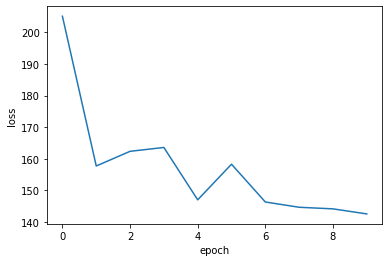

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

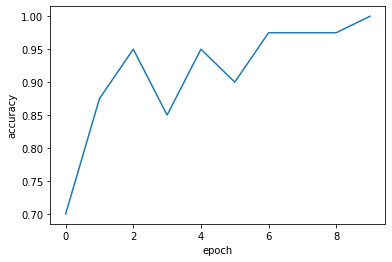

In [ ]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()

In [ ]:
! ./bbb/bbb3_train

epoch_num : 10
batch  number  : 10,4
learning ratio : 0.01
total_loss (batch): epoch 0 : loss 1743.32 : Acc 0.275 11
total_loss (all)  : epoch 0 : loss 244.095 : Acc 0.7 28
total_loss (batch): epoch 1 : loss 1520.25 : Acc 0.7 28
total_loss (all)  : epoch 1 : loss 178.631 : Acc 0.85 34
total_loss (batch): epoch 2 : loss 1474.65 : Acc 0.8 32
total_loss (all)  : epoch 2 : loss 173.712 : Acc 0.9 36
total_loss (batch): epoch 3 : loss 1457.47 : Acc 0.875 35
total_loss (all)  : epoch 3 : loss 155.055 : Acc 0.975 39
total_loss (batch): epoch 4 : loss 1448.13 : Acc 0.975 39
total_loss (all)  : epoch 4 : loss 150.776 : Acc 0.975 39
total_loss (batch): epoch 5 : loss 1444.64 : Acc 0.925 37
total_loss (all)  : epoch 5 : loss 147.853 : Acc 0.975 39
total_loss (batch): epoch 6 : loss 1441.38 : Acc 0.95 38
total_loss (all)  : epoch 6 : loss 149.612 : Acc 0.975 39
total_loss (batch): epoch 7 : loss 1440.6 : Acc 0.95 38
total_loss (all)  : epoch 7 : loss 148.838 : Acc 0.975 39
total_loss (batch): epoch

In [ ]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("[OUT]",path)
print("epoch =", len(loss))
print( loss )
print(acc)

[OUT] ./bbb/bbb3.out
epoch = 10
[244.095001, 178.630585, 173.711655, 155.055176, 150.776489, 147.85318, 149.612457, 148.838348, 144.955353, 144.126343]
[0.7, 0.85, 0.9, 0.975, 0.975, 0.975, 0.975, 0.975, 1.0, 1.0]


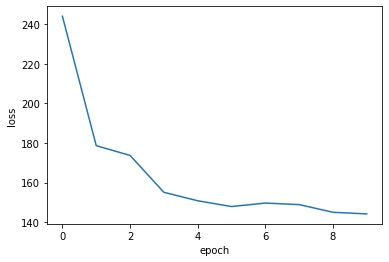

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

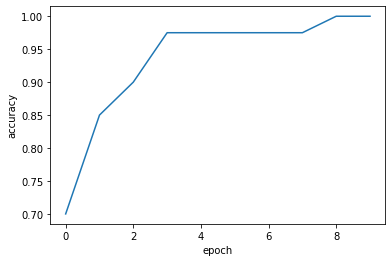

In [ ]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()